# Chicago Crime Dataset Analysis 

## 1.Abstract
This Notebook contains Chicago crime data analysis for the last ten years (2011-2021) <br>
The dataset was collected from the ‘city of chicago’ official website which has many public datasets.<br>
In this research, I would like to analyze the Chicago crime pattern from multiple angles. Since the beginning of the 20th century, the Chicago Police Department's Bureau of Records has been tracking crime in Chicago. The city's total crime rate and violent crime rate are both higher than the national average. Chicago was responsible for roughly half of the increase in homicides in the United States in 2016, despite the fact that national crime rates remain at historic lows.
## 2.Dataset Description
For this particular project I have used three datasets ,the first dataset is the actual crime dataset which contains information about the crime that is time, location, category and primary type. The second dataframe is about the districts in chicago which contains district name and chicago district number which I will further use for getting an comprehensive idea about the crimes in chicago based on different districts. The last dataset is about the comunity area nmaes in chicago which has community area codes and respective name of that area number. The dataset consists of 22 columns and 7.5 Million rows (dataset size 1.78GB). The dataset has information about the
reported crimes from 2001 in the city of chicago except for the murders.

* The dataset about the crime and IUCR can be found in the Chicago's official [website.](https://data.cityofchicago.org/Public-Safety/Crimes-One-year-prior-to-present/x2n5-8w5q)
* The dataset which had information about disricts was also from the same portal. 
* Chicago Community Areas is the subject of the third dataframe. This dataset was collected from a public [website](https://datahub.cmap.illinois.gov/dataset/community-data-snapshots-raw-data/resource/8c4e096e-c90c-4bef-9cf1-9028d094296e?inner_span=True) including multiple datasets about various states. 
--- 


<br>

## 3.Objective

The aim of the project is to find out the crimes which occured more often, find the crime rate trend across the years and during which month and hour of the day crime rate was highest. Using the second dataset I want to get the district naes and join the two dataframes so that we can evaluate the crimes based on district. Intitially the dataset had many null values and even the schema was not properly defined so I have to perform EDA before I do any transformation on the data. As the spark doesn't have any inbuilt libraries for plotting I will be using matplotlib to plot and I will be also using sql functions to effectively work on dataframe. 

### Importing all the useful Libraries

In [ ]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
import csv
from pyspark.sql.types import *
from pyspark.sql.functions import format_number, when
import pandas as pd
import matplotlib.pyplot as plt
import os
import pandas as pd
import datetime
from pyspark.sql.functions import *
from pyspark.sql import functions as F

In [ ]:
import pyspark
spark = pyspark.sql.SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [ ]:
spark

## 4.Dataset

### Defining the schema

In [ ]:
crime_schema = StructType([StructField("ID", StringType(), True),
                            StructField("Case Number", StringType(), True),
                            StructField("Date", StringType(), True ),
                            StructField("Block", StringType(), True),
                            StructField("IUCR", StringType(), True),
                            StructField("Primary Type", StringType(), True  ),
                            StructField("Description", StringType(), True ),
                            StructField("Location Description", StringType(), True ),
                            StructField("Arrest", BooleanType(), True),
                            StructField("Domestic", BooleanType(), True),
                            StructField("Beat", StringType(), True),
                            StructField("District", IntegerType(), True),
                            StructField("Ward", StringType(), True),
                            StructField("Community Area", StringType(), True),
                            StructField("FBI Code", StringType(), True ),
                            StructField("X Coordinate", DoubleType(), True),
                            StructField("Y Coordinate", DoubleType(), True ),
                            StructField("Year", IntegerType(), True),
                            StructField("Updated On", DateType(), True ),
                            StructField("Latitude", DoubleType(), True),
                            StructField("Longitude", DoubleType(), True),
                            StructField("Location", StringType(), True )
                            ])

### Reading the dataframe (First Dataframe)

In [ ]:
#Reading the first dataframe as df1
df1 = spark.read.csv("crime_chicago.csv",sep=",", header=True, nullValue='NA', schema=crime_schema)

In [ ]:
df1.show()

+--------+-----------+--------------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+----------+------------+-------------+--------------------+
|      ID|Case Number|                Date|               Block|IUCR|      Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+--------------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+----------+------------+-------------+--------------------+
|10224738|   HY411648|09/05/2015 01:30:...|     043XX S WOOD ST|0486|           BATTERY|DOMESTIC BATTERY ...|           RESIDENCE| false|    true|0924|       9|

<b>We can see there are many records that have null values and even some columns are not useful, in the next steps we will be cleaning the dataset for further analysis.<b>

In [ ]:
!wc -l crime_chicago.csv

7495190 crime_chicago.csv


Looking at the features

In [ ]:
df1.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: boolean (nullable = true)
 |-- Domestic: boolean (nullable = true)
 |-- Beat: string (nullable = true)
 |-- District: integer (nullable = true)
 |-- Ward: string (nullable = true)
 |-- Community Area: string (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: double (nullable = true)
 |-- Y Coordinate: double (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Updated On: date (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Location: string (nullable = true)



### Counting the number of null values

In [ ]:
#counting number of null values 
from pyspark.sql.functions import isnan, when, count, col
df1.select([count(when(col(c).isNull(), c)).alias(c) for c in df1.columns]).show()


+---+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+------+--------------+--------+------------+------------+----+----------+--------+---------+--------+
| ID|Case Number|Date|Block|IUCR|Primary Type|Description|Location Description|Arrest|Domestic|Beat|District|  Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|Updated On|Latitude|Longitude|Location|
+---+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+------+--------------+--------+------------+------------+----+----------+--------+---------+--------+
|  0|          4|   0|    0|   0|           0|          0|                9023|     0|       0|   0|      47|614840|        613478|       0|       77307|       77307|   0|   7495189|   77307|    77307|   77307|
+---+-----------+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+------+--------------+--------+------------+---

## 4.1 Analysis

### For better understanding I have only considered last ten years data

In [ ]:
#Creating a list of years for filtering the df1
last_ten_years=['2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021']

In [ ]:
#Applying filter
df2=df1.filter(df1.Year.isin(last_ten_years))

In [ ]:
df2.select(F.countDistinct("Year")).show()

+--------------------+
|count(DISTINCT Year)|
+--------------------+
|                  11|
+--------------------+



### Different crime types
Before we actually analyze the data its importnat to get an idea about the data so here we can get an idea about different crimes happening across chicago, based on this we can remove crimes that are not imperative and I will try to merge the crimes which are similar. 

In [ ]:
#unique values in primary type column
df2.select('Primary Type').distinct().rdd.map(lambda r: r[0]).collect()

['OFFENSE INVOLVING CHILDREN',
 'CRIMINAL SEXUAL ASSAULT',
 'STALKING',
 'PUBLIC PEACE VIOLATION',
 'OBSCENITY',
 'NON-CRIMINAL (SUBJECT SPECIFIED)',
 'ARSON',
 'GAMBLING',
 'CRIMINAL TRESPASS',
 'ASSAULT',
 'NON - CRIMINAL',
 'LIQUOR LAW VIOLATION',
 'MOTOR VEHICLE THEFT',
 'THEFT',
 'BATTERY',
 'ROBBERY',
 'HOMICIDE',
 'PUBLIC INDECENCY',
 'CRIM SEXUAL ASSAULT',
 'HUMAN TRAFFICKING',
 'INTIMIDATION',
 'PROSTITUTION',
 'DECEPTIVE PRACTICE',
 'CONCEALED CARRY LICENSE VIOLATION',
 'SEX OFFENSE',
 'CRIMINAL DAMAGE',
 'NARCOTICS',
 'NON-CRIMINAL',
 'OTHER OFFENSE',
 'KIDNAPPING',
 'BURGLARY',
 'WEAPONS VIOLATION',
 'OTHER NARCOTIC VIOLATION',
 'INTERFERENCE WITH PUBLIC OFFICER',
 'RITUALISM']

### Dropping columns which are unecessary

In [ ]:
dataset = df2.drop('Case Number')\
            .drop('FBI Code')\
            .drop('Updated On')

In [ ]:
#dropping null values
dataset = dataset.na.drop()

In [ ]:
#checking if any null values exist
dataset.select([count(when(col(c).isNull(), c)).alias(c) for c in dataset.columns]).show()

+---+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+----+--------------+------------+------------+----+--------+---------+--------+
| ID|Date|Block|IUCR|Primary Type|Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|X Coordinate|Y Coordinate|Year|Latitude|Longitude|Location|
+---+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+----+--------------+------------+------------+----+--------+---------+--------+
|  0|   0|    0|   0|           0|          0|                   0|     0|       0|   0|       0|   0|             0|           0|           0|   0|       0|        0|       0|
+---+----+-----+----+------------+-----------+--------------------+------+--------+----+--------+----+--------------+------------+------------+----+--------+---------+--------+



#### Removing all the unecessary crime types 

In [ ]:
dataset=dataset.filter((dataset["Primary Type"]  !=  'NON-CRIMINAL (SUBJECT SPECIFIED)') & 
               (dataset["Primary Type"]  !=  'OTHER OFFENSE') &
               (dataset["Primary Type"]  !=  'STALKING')&
               (dataset["Primary Type"]  !=  'NON - CRIMINAL')&
               (dataset["Primary Type"]  !=  'ARSON'))  

#### Merging the crime types which are similar

In [ ]:
dataset = dataset.withColumn("Primary Type", \
                               when((dataset["Primary Type"] == 'SEX OFFENSE') | \
                                    (dataset["Primary Type"] == 'PROSTITUTION') ,'CRIM SEXUAL ASSAULT').otherwise(dataset['Primary Type']))

## 5. Data Analysis
### 5.1 Crime Primary Type Analysis

In [ ]:
#crime type and respective counts
primaryCount = dataset.groupby('Primary Type').count()
print('Different type of crimes which occur more')
primaryCount.orderBy('count', ascending=False).show()

Different type of crimes which occur more
+--------------------+------+
|        Primary Type| count|
+--------------------+------+
|               THEFT|669273|
|             BATTERY|552073|
|     CRIMINAL DAMAGE|324105|
|           NARCOTICS|222543|
|             ASSAULT|209507|
|  DECEPTIVE PRACTICE|167464|
|            BURGLARY|158858|
| MOTOR VEHICLE THEFT|130240|
|             ROBBERY|115942|
|   CRIMINAL TRESPASS| 73231|
|   WEAPONS VIOLATION| 54740|
| CRIM SEXUAL ASSAULT| 35260|
|OFFENSE INVOLVING...| 23715|
|PUBLIC PEACE VIOL...| 22391|
|INTERFERENCE WITH...| 12095|
|            HOMICIDE|  6488|
|CRIMINAL SEXUAL A...|  3679|
|LIQUOR LAW VIOLATION|  3581|
|            GAMBLING|  3520|
|          KIDNAPPING|  2092|
+--------------------+------+
only showing top 20 rows



## The top ten crimes in chicago 

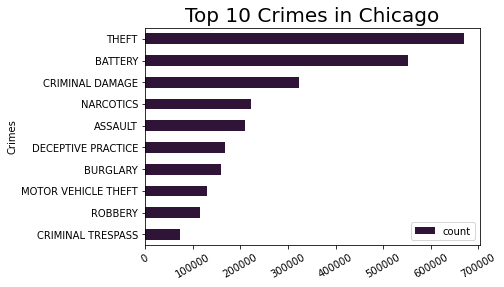

In [ ]:
#plotting top 10 crimes 
pdf = primaryCount.toPandas()
pdf = pdf.sort_values(by="count", ascending= True)
pdf = pdf.tail(10)
pdf.plot(kind='barh', x='Primary Type', y='count', colormap='twilight_shifted')
plt.title("Top 10 Crimes in Chicago", fontdict = {'fontsize': 20,  'color': '#000000'})
plt.ylabel('Crimes')
plt.xticks(rotation=30)
plt.show()

 According to the data, the most prevalent crimes in Chicago are <b>Theft and Battery.</b>  Criminal Damage and Narcotics appear in the third and fourth columns of the numerical table. In terms of frequency, the crimes of Assault, Burglary, Deceptive Practice, Motor Vehicle Theft, and Robbery are next in line.

### 5.2 Crime frequency over time

In [ ]:
#year wise crime count
year_wise = dataset.groupBy(['Year'])\
                     .count()\
                     .orderBy(['Year', 'count'], ascending=[True, False])
print()
year_wise.show(10, truncate=False)


+----+------+
|Year|count |
+----+------+
|2011|330055|
|2012|316943|
|2013|287827|
|2014|256118|
|2015|239871|
|2016|248581|
|2017|246547|
|2018|245299|
|2019|240820|
|2020|194254|
+----+------+
only showing top 10 rows



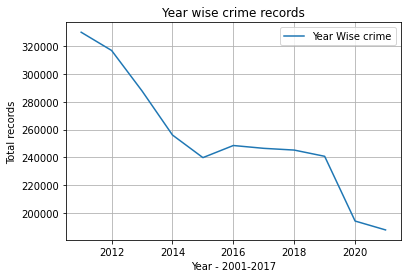

In [ ]:
#plotting time-series graph for crime count
year_wise = year_wise.toPandas()
fig, ax = plt.subplots()
ax.plot(year_wise['Year'], year_wise['count'], label='Year Wise crime')
ax.set(xlabel='Year - 2001-2017', ylabel='Total records',
       title='Year wise crime records')
ax.grid(which='both', axis='both')
ax.legend()

According to the results the number of crimes are in decline from 2010 to 2015. In 2015, total number of crimes seemed to have its lowest value. However, there was increase in the crimes . One of the main reason was Black Lives Matter protests have scared law enforcement officers from doing the proactive policing necessary to prevent crime, while at the same time criminals have been emboldened because they now know police are backing off from aggressive tactics. [(Reference)](https://www.vox.com/policy-and-politics/2017/4/18/15339436/murder-rise-2016-2015)

### 5.3 Monthly Crime Analysis

### Extracting Year,month and time from date&time column for further evaluation. 

In [ ]:
#converting date time column type to timestamp
dataset = dataset.withColumn('datetime', to_timestamp('Date', 'MM/dd/yyyy hh:mm:ss a'))

In [ ]:
mon_wise = dataset.select("datetime", month(col("datetime")).alias("dmonth"), )

In [ ]:
#month wise crimes
monthcount = mon_wise.groupby('dmonth').count()
monthcount.orderBy('dmonth', ascending=True).show()

+------+------+
|dmonth| count|
+------+------+
|     1|219317|
|     2|190191|
|     3|224068|
|     4|221165|
|     5|249106|
|     6|252011|
|     7|263232|
|     8|260098|
|     9|241842|
|    10|240443|
|    11|218085|
|    12|214624|
+------+------+



The table shows the month and total number of crimes occured in that month. As the table is not comprehensive I have visualized it for better understanding. 

### Crime trend across months

In [ ]:
#sorting rows according to month for plotting
dfm = monthcount.orderBy('dmonth', ascending=True)

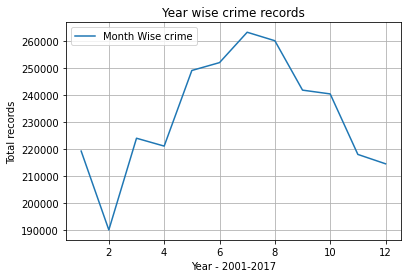

In [ ]:
#plotting monthly crime rate
dfm = dfm.toPandas()
fig, ax = plt.subplots()
ax.plot(dfm['dmonth'], dfm['count'], label='Month Wise crime')
ax.set(xlabel='Year - 2001-2017', ylabel='Total records',
       title='Year wise crime records')
ax.grid(which='both', axis='both')
ax.legend()

We can observe that during June, July, and August, the highest crime rates are recorded. That is usually in summer. This may seem strange, but according to various [articles](https://www.vox.com/2014/6/17/5818432/lock-your-doors-crime-is-worst-in-the-summer), the crime rate peaks during the summer, and the same is true for the state of Illinois.


### 5.4 Hourly Crime Analysis

### Crime trend during a day

In [ ]:
#extracting hours from dataframe 
only_hrs = dataset.select("datetime", hour(col("datetime")).alias("dhour"), )

In [ ]:
#counting number of crimes each hour
hrs_count = only_hrs.groupby('dhour').count()
hrs_count = hrs_count.orderBy('dhour', ascending=True)

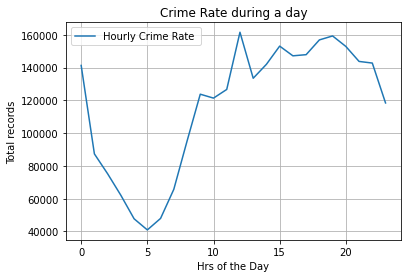

In [ ]:
#plotting the crime rate based on hour of the day
hrs_count = hrs_count.toPandas()
fig, ax = plt.subplots()
ax.plot(hrs_count['dhour'], hrs_count['count'], label='Hourly Crime Rate ')
ax.set(xlabel='Hrs of the Day', ylabel='Total records',
       title='Crime Rate during a day')
ax.grid(which='both', axis='both')
ax.legend()

To find the relation between crime rate and hours of the day I extracted the hour and plotted them, we can observe Violence committed by peaks in the afterschool hours and in the evenings. The incidence of violence committed increases through the afternoon and early evening hours, peaking between 6 p.m. and 9 p.m. 

## 6. Analysis using second and third dataset

### Reading the Second Dataframe (District name)

In [ ]:
#second dataframe 
distrtict = spark.read.csv("Police_Stations.csv",sep=",", header=True, nullValue='NA')

#### There were many records which were unnecessary, before merging I have cleaned the data.
These are few steps I followed for cleaning the data. 

In [ ]:
#list to filter the dataframe 
dis_list= ['31','12','22','1','6','16','3','20','5','19','15','9','17','4','8','7','10','25','24','11','14','2','18','21']

In [ ]:
district = distrtict.filter(distrtict.DISTRICT.isin(dis_list))

In [ ]:
#changing column type 
district = district.withColumn("DISTRICT", district["DISTRICT"].cast(IntegerType()))

In [ ]:
dis_mer_df = dataset.filter(dataset.District.isin(dis_list))

In [ ]:
#selecting the required columns 
district = district.select('DISTRICT','DISTRICT NAME')

In [ ]:
dis_mer_df = dis_mer_df.select('District')

### Merging the 2nd dataframe with intial dataframe. (Using Inner Join)
The primary reason I utilized the second dataframe is because the district column in the first dataframe had merely code numbers, which provided no meaningful information. The second dataframe contained both district numbers and district names, therefore merging them would result in district names that make more sense.

### 6.1 Location-based Anlaysis


In [ ]:
#joining dataframes
district_df = dis_mer_df.join(district,dis_mer_df.District == district.DISTRICT,"inner")

In [ ]:
#counting number of crimes based on district 
dcount = district_df.groupby('DISTRICT NAME').count()
dcount.orderBy("count", ascending=False).show()

+--------------+------+
| DISTRICT NAME| count|
+--------------+------+
|      Harrison|195003|
|  Chicago Lawn|180590|
|       Gresham|171141|
| South Chicago|159920|
|     Englewood|156677|
| Grand Central|152445|
|Grand Crossing|137621|
|     Near West|137154|
|    Near North|136407|
|       Deering|130967|
|       Central|129786|
|     Town Hall|128037|
|         Ogden|127894|
|       Calumet|124458|
|     Wentworth|118537|
|        Austin|117776|
|   Shakespeare|101129|
|Jefferson Park| 91124|
|   Morgan Park| 89480|
|   Rogers Park| 80994|
+--------------+------+
only showing top 20 rows



This is the output we get after using second dataframe, now we have a clear idea about the districts in chicago. 

In [ ]:
#sorting the dataframe for plottting 
dcount = dcount.orderBy("count", ascending=False)

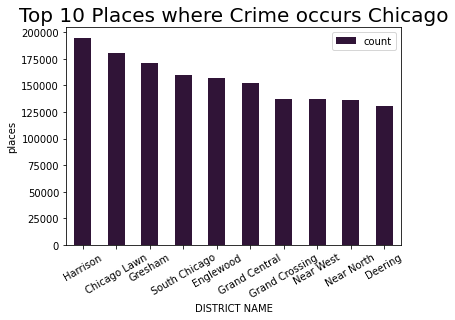

In [ ]:
#plotting district names                                                                    
dcount = dcount.toPandas()
dcount = dcount.head(10)
dcount.plot(kind='bar', x='DISTRICT NAME', y='count', colormap='twilight_shifted')
plt.title("Top 10 Places where Crime occurs Chicago", fontdict = {'fontsize': 20,  'color': '#000000'})
plt.ylabel('places')
plt.xticks(rotation=30)
plt.show()

The above graph depicts the top 10 districts where crime rate is highest. 

### 6.2 Comparison between arrested and non-arrested crimes

In [ ]:
#filtering data based on arrest type
arrested = dataset[dataset['Arrest'] == True]
not_arrested = dataset[dataset['Arrest'] == False]

In [ ]:
arrested_df = arrested.groupby('Year').count()
arrested_df = arrested_df.orderBy('Year',ascending=True)

In [49]:
arr_prim = arrested.groupby('Primary Type').count()
arr_prim = arr_prim.orderBy("count", ascending=False)

### Crime type where most arrests were made.

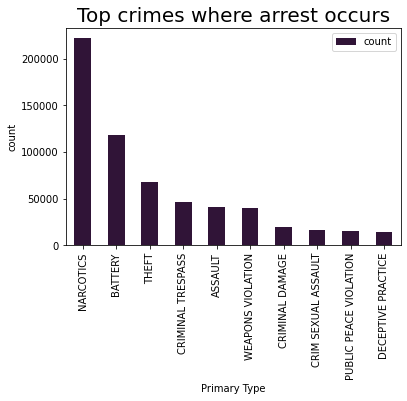

In [50]:
arr_prim = arr_prim.toPandas()
arr_prim = arr_prim.head(10)
arr_prim.plot(kind='bar', x='Primary Type', y='count', colormap='twilight_shifted')
plt.title("Top crimes where arrest occurs", fontdict = {'fontsize': 20,  'color': '#000000'})
plt.ylabel('count')
plt.xticks(rotation=90)
plt.show()

In [51]:
not_arrested_df = not_arrested.groupby('Year').count()
not_arrested_df = not_arrested_df.orderBy('Year',ascending=True)

In [52]:
arrested_df

DataFrame[Year: int, count: bigint]

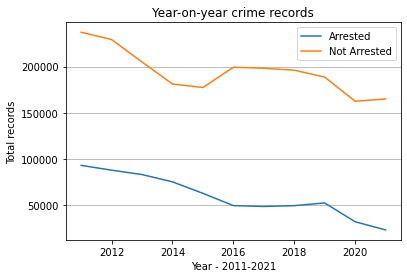

In [53]:
#plotting arrrested and non-arrested graph
arrested_df = arrested_df.toPandas()
not_arrested_df = not_arrested_df.toPandas()
fig, ax = plt.subplots()
ax.plot(arrested_df['Year'], arrested_df['count'], label='Arrested')
ax.plot(not_arrested_df['Year'], not_arrested_df['count'], label='Not Arrested')

ax.set(xlabel='Year - 2011-2021', ylabel='Total records',
       title='Year-on-year crime records')
ax.grid(which='both', axis='y')
ax.legend()

From the graph we can observe that the arrest and non-arrest rate has been constant over the period, moreover in both cases the rate has been declining. 

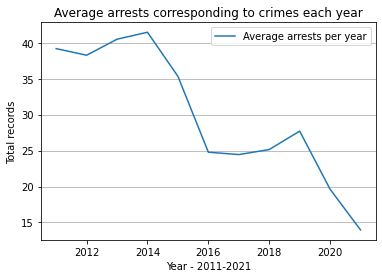

In [54]:
#average arrests compared to no arrests
arrested_df['avg'] = (arrested_df['count']/not_arrested_df['count']*100)
fig, ax = plt.subplots()
ax.plot(arrested_df['Year'], arrested_df['avg'], label='Average arrests per year')
ax.set(xlabel='Year - 2011-2021', ylabel='Total records',
       title='Average arrests corresponding to crimes each year')
ax.grid(which='both', axis='y')
ax.legend()

The average arrest rate was initially high over the period, but it took a great plummet from 2014. Normally, arrests are made when serious crimes occur. This demonstrates that initially, crimes were more serious, and the number of major crimes decreased significantly over time.

### 6.3 Third Dataframe (Chicago's Community Areas')

In [55]:
#reading third dataframe
communityarea = spark.read.csv("communityarea.csv",sep=",", header=True, nullValue='NA')

In [56]:
#selecting useful columns
communityarea = communityarea.select("GEOID","GEOG")

In [57]:
communityarea = communityarea.select(col("GEOID").alias("com_num"), col("GEOG").alias("com_name"))

In [58]:
dataset_com = dataset.select("Primary Type", "Community Area")
dataset_com = dataset_com.select(col("Primary Type").alias("primary"), col("Community Area").alias("c_id"))

In [59]:
#performing merge using inner join
com_df3 = communityarea.join(dataset_com,communityarea.com_num == dataset_com.c_id,"inner")

In [60]:
com_df1 = com_df3.groupby('com_name').count()
com_df1 = com_df1.orderBy('count',ascending=False)

### Community names with highest crimes

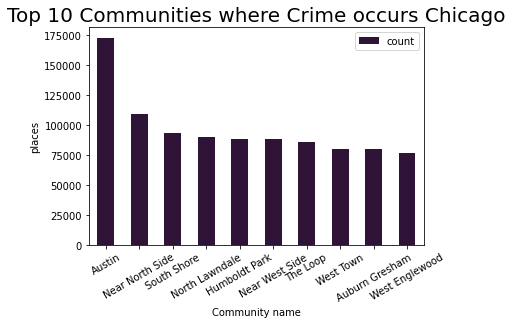

In [61]:
#plotting 
com_df = com_df1.toPandas()
com_df = com_df.head(10)
com_df.plot(kind='bar', x='com_name', y='count', colormap='twilight_shifted')
plt.title("Top 10 Communities where Crime occurs Chicago", fontdict = {'fontsize': 20,  'color': '#000000'})
plt.xlabel('Community name')
plt.ylabel('places')
plt.xticks(rotation=30)
plt.show()

Austin has the highest crime rate in Chicago's 15th district's neighborhood areas, of which Area 4 is a portion. Located on the West Side of the city, it is the third largest community area in terms of people and the second largest in terms of land area. Other community areas with high crime rates also fall under Area 4, making it the most dangerous neighborhood in Chicago.<br>

<img  src="https://user-images.githubusercontent.com/89949851/166743258-83ec4a9d-e063-4385-b7e6-db63bdfdca29.jpeg">

#### To gain a better knowledge of the crimes in Area 4, I attempted to create a scatterd plot of the most frequent offenses.


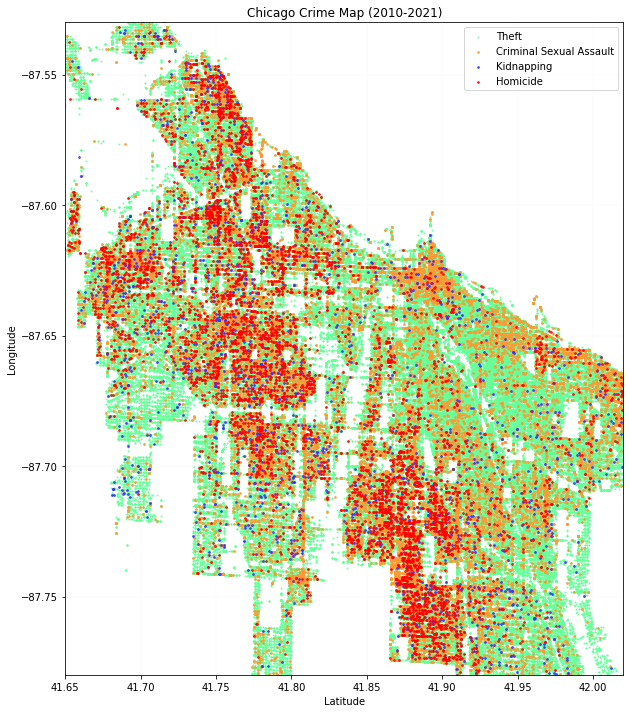

In [62]:

crime_geo = dataset.select('Primary Type', 'Latitude', 'Longitude')
homicides = crime_geo.filter((crime_geo["Primary Type"] =='HOMICIDE'))
homicides = homicides.toPandas()
# get homicides

# get kidnappings
kidnappings = crime_geo.filter((crime_geo["Primary Type"]  == 'KIDNAPPING'))
kidnappings = kidnappings.toPandas()
# get criminal sexual assaults
sexual_assaults = crime_geo.filter((crime_geo["Primary Type"]  == 'CRIM SEXUAL ASSAULT'))
sexual_assaults = sexual_assaults.toPandas()
# get thefts
thefts = crime_geo.filter((crime_geo["Primary Type"]  == 'THEFT'))
thefts = thefts.toPandas()
# create scatter map plot
fig,ax= plt.subplots(1, 1, figsize=(10,12))
plt.xlim(41.65, 42.02) # (minLat, maxLat)
plt.ylim(-87.78, -87.53) # (minLong, maxLong)

ax.scatter(thefts['Latitude'], thefts['Longitude'],\
                            s=1, alpha=0.8, color='#66ff99', label='Theft')
ax.scatter(sexual_assaults['Latitude'], sexual_assaults['Longitude'],\
                            s=3, alpha=0.8, color='#ff9933', label='Criminal Sexual Assault')
ax.scatter(kidnappings['Latitude'], kidnappings['Longitude'],\
                            s=3, alpha=0.8, color='#3333ff', label='Kidnapping')
ax.scatter(homicides['Latitude'], homicides['Longitude'],\
                            s=3, alpha=0.8, color='#ff0000', label='Homicide')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Chicago Crime Map (2010-2021)')
plt.legend(loc='upper right', frameon=True)
plt.grid(linestyle = '--', linewidth = 0.05)
plt.show()

From the plotting, we can deduce that crimes such as homicide and sexual assault are more prevalent in the core of Area 4 and its surrounding suburbs, whereas the number of thefts increases as we approach the city limits.

## 6.Conclusion
We may observe the most frequently occurring crimes and the frequently occurring places where crimes occurred based on the analysis and visualization results. We where also able to find the relation crime trend across months and hours of the day. The city's overall crime rate, especially the violent crime rate, is higher than the US average. Chicago was responsible for nearly half of 2016's increase in homicides in the US, though the nation's crime rates remain near historic lows. Following are major finding of this analysis:
<br>

* Theft, Battery are by far the most frequent crimes in Chicago. Criminal Damage and Narcotics are falling into the third and fourth column in number. Assault, Burglary, Deceptive Practice, Motor Vehicle Theft and Robbery are next in the line in terms of frequency.
* According to the results the number of crimes are in decline from 2010 to 2015. In 2015, total number of crimes seemed to have its lowest value. However, there was increase in the crimes . 
* During June, July, and August, the highest crime rates are recorded that is usually in summer. It is true for most of the places that crime rate increases during summer. The crime rate appears to have peaked in the summer and remained at its maximum level from June to August, while it was lower in the winter, reaching its lowest point in February. The monthly pattern was steady throughout the entire year.
* The crime rate is higher in certain District in the Southern part of Chicago. More specifically, District Harrison, Greesham, and Chicago Lawn have the highest crime rate.
* The arrest has remained relatively constant for a longer period of time in different years with the exception of 2016 which the trend was relatively decreasing after May. The results also showed that the number of arrests has its lowest value in 2020 and its highest value in 2012.
* The most arrests belongs to Narcotics, Battery, Theft, Criminal Trespass, and Assault, respectively.
* The ratio of Arrest has peaked in 2014 following a sharp drop between 2014 and 2016. The ratio of the arrests has its lowest value in 2016.
* The Area 4 is on the south side of the city. The possible reason for the crime rate being too high may be the proximity of Riverdale to the freeway and the streets. Sadly, the economic conditions in the region are also quite poor, with most people making less than $8,000 a year.
* Crimes such as homicide and sexual assault are more prevalent in the core of Area 4 and its surrounding suburbs, whereas the number of thefts increases as we approach the city limits.
* Austin has the highest crime rate in Chicago's 15th district's neighborhood areas, of which Area 4 is a portion. Located on the West Side of the city, it is the third largest community area in terms of people and the second largest in terms of land area.

If our data analytics can provide us with all of this information about the security status of the city of Chicago, I believe that a larger data analytics project will provide significantly more valuable information that can be used as a powerful resource for taking prudent actions to improve the security status of our cities.